# Preprocessing and Modeling
Diagnosing Pneumonia with X-Ray image data.

## Table of Contents
* [Data Loading and EDA](#chapter1)
    
* [Modeling](#chapter2)
    

The first half of this notebook is the same as the Data Wrangling and EDA notebook. Because of the way the data is organized/transformed, it seemed more natural to proceed to the preprocessing/modeling in the same notebook (instead of loading into a separate one), so I'll make a link to where the Modeling begins. 

    https://linuxhint.com/add-table-contents-jupyter-notebook/

## Data Loading and EDA <a class="anchor" id="chapter1"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
#from PyTorch transfer learning tutorial nb
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
from pathlib import Path
from collections import Counter

In [4]:
data_dir = Path('../data/chest_xray')
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
val_dir = data_dir / 'val'

# Training Data

To begin, we need to load the images in our training set. Essentially, we will make a list of paths to each image, and then use a separate function later to read the image file. 

I found these resources to be very helpful for learning how to load in image data

        https://docs.python.org/3/library/glob.html
        https://www.kaggle.com/code/aakashnain/beating-everything-with-depthwise-convolution

In [5]:
normal_path = train_dir / 'NORMAL'
pneumo_path = train_dir / 'PNEUMONIA'

#lists of the images
normal = normal_path.glob('*jpeg')
pneumo = pneumo_path.glob('*jpeg')

# we will store the normal images with a 0, pneumo with a 1
train = []
for x in normal:
    train.append((x,0))
for y in pneumo:
    train.append((y,1))

In [6]:
#lets take a look at this
train[:3]

[(WindowsPath('../data/chest_xray/train/NORMAL/IM-0115-0001.jpeg'), 0),
 (WindowsPath('../data/chest_xray/train/NORMAL/IM-0117-0001.jpeg'), 0),
 (WindowsPath('../data/chest_xray/train/NORMAL/IM-0119-0001.jpeg'), 0)]

In [7]:
train[-3:]

[(WindowsPath('../data/chest_xray/train/PNEUMONIA/person9_bacteria_39.jpeg'),
  1),
 (WindowsPath('../data/chest_xray/train/PNEUMONIA/person9_bacteria_40.jpeg'),
  1),
 (WindowsPath('../data/chest_xray/train/PNEUMONIA/person9_bacteria_41.jpeg'),
  1)]

This looks like what we wanted, a single list with the paths to the normal images at the beginning, and pnemo images at the end. 

In [8]:
#create a pandas dataframe from this list
trainDF = pd.DataFrame(train, columns = ['image','label'],index = None)

In [9]:
trainDF.head()

,image,label
0,..\data\chest_xray\train\NORMAL\IM-0115-0001.jpeg,0
1,..\data\chest_xray\train\NORMAL\IM-0117-0001.jpeg,0
2,..\data\chest_xray\train\NORMAL\IM-0119-0001.jpeg,0
3,..\data\chest_xray\train\NORMAL\IM-0122-0001.jpeg,0
4,..\data\chest_xray\train\NORMAL\IM-0125-0001.jpeg,0


In [10]:
trainDF.tail()

,image,label
5211,..\data\chest_xray\train\PNEUMONIA\person99_vi...,1
5212,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1
5213,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1
5214,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1
5215,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1


In [11]:
 trainDF.label.value_counts()

1    3875
0    1341
Name: label, dtype: int64

So, in our training data, we have 3875 images where the patient has pneumonia, and 1341 where the person is normal. 

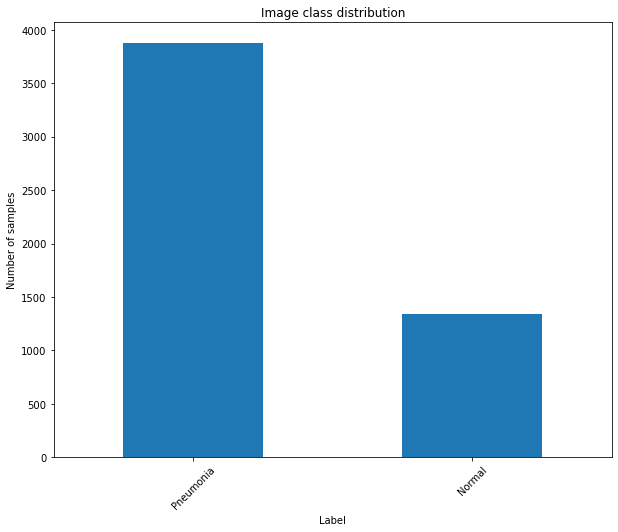

In [12]:
plt.figure(figsize = (10,8))
trainDF.label.value_counts().plot(kind = 'bar')
plt.xticks(ticks = [0,1],labels=['Pneumonia','Normal'],rotation = 45)
plt.xlabel('Label')
plt.ylabel('Number of samples')
plt.title('Image class distribution')
plt.show()

    https://www.kaggle.com/code/homayoonkhadivi/medical-diagnosis-with-cnn-transfer-learning

# Images in our training set

Here are 5 pictures of X-Ray's that were diagnosed with pneumonia

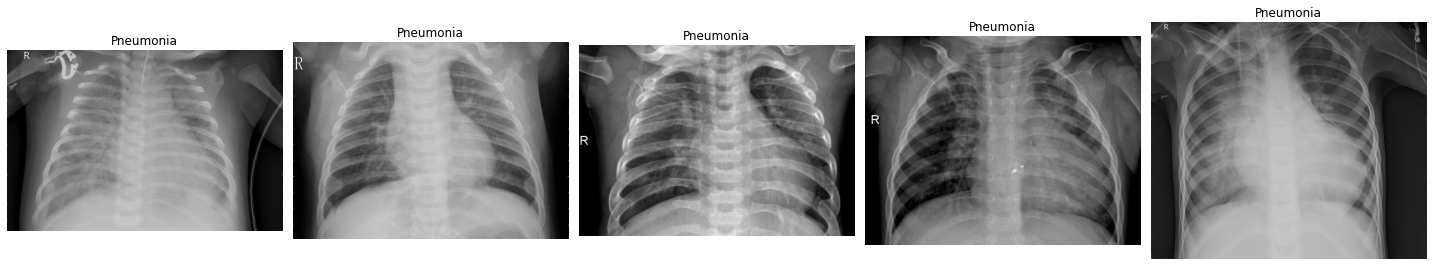

In [13]:
pneumo_pics = (trainDF[trainDF['label']==1]['image'].iloc[:5]).tolist()
#normal_pics = (trainDF[trainDF['label']==0]['image'].iloc[:5]).tolist()
plt.figure(figsize=(20, 10))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(pneumo_pics[i])
    #img = plt.imread(os.path(normal_path))
    plt.imshow(img, cmap='gray')
    plt.title("Pneumonia")
    plt.axis('off')
    
plt.tight_layout()

In [14]:
pneumo_pics

[WindowsPath('../data/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1001_bacteria_2932.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1002_bacteria_2933.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1003_bacteria_2934.jpeg')]

And here are 5 pictures of X-Ray's that were diagnosed as normal.

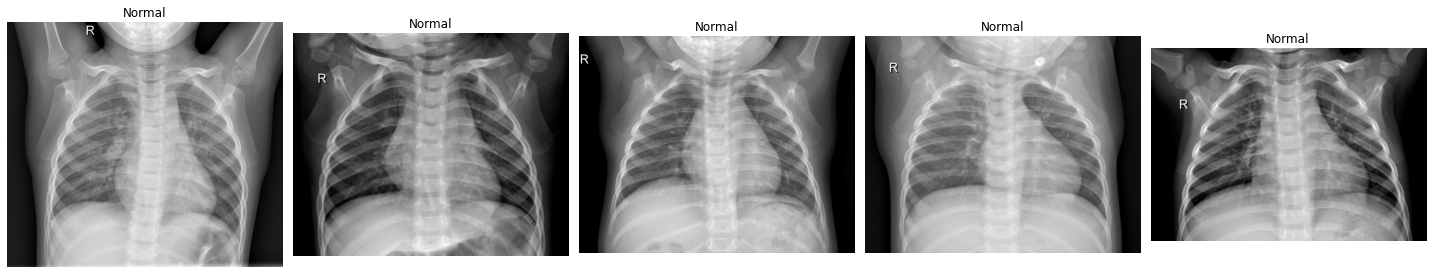

In [15]:
normal_pics = (trainDF[trainDF['label']==0]['image'].iloc[:5]).tolist()
plt.figure(figsize=(20, 10))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(normal_pics[i])
    #img = plt.imread(os.path(normal_path))
    plt.imshow(img, cmap='gray')
    plt.title("Normal")
    plt.axis('off')
    
plt.tight_layout()

Lets take a look at a bigger version of a normal image, this time with the grayscale colorbar added

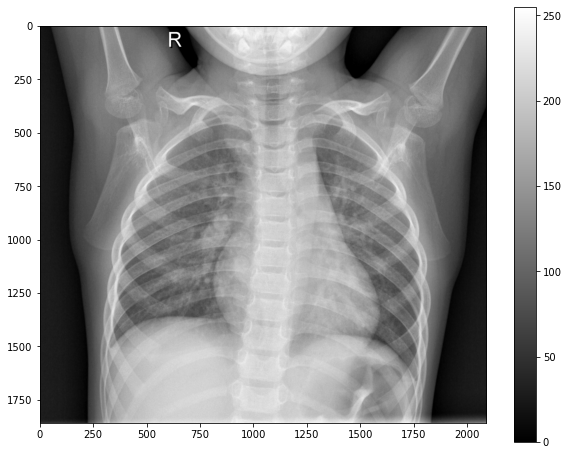

In [16]:
plt.figure(figsize = (10,8))
img = plt.imread(normal_pics[0])
plt.imshow(img,cmap='gray')
plt.colorbar()
plt.show()

In [17]:
img.shape

(1858, 2090)

In [18]:
#Lets see what some of the other image dimensions are. 

for i in range(5):
    img = plt.imread(normal_pics[i])
    print(img.shape)

(1858, 2090)
(1152, 1422)
(1434, 1810)
(1279, 1618)
(1125, 1600)


In [19]:
for i in range(5):
    img = plt.imread(pneumo_pics[i])
    print(img.shape)

(760, 1152)
(768, 1072)
(863, 1244)
(940, 1242)
(1280, 1488)


We will want to include resizing in our preprocessing to account for the differences in image size seen here. 

# Image Augmentations

We will use the torchvision transforms library in this section. There are 2 main objectives here. The first is to balance our classes, that is to use augmentations to increase the number of "normal" class images in our training data to match the number of "pneumonia" class images. The second is to resize the images and normalize their channel values to have consistent data to train our network on. For now we will use the mean and std from imagenet for normalization ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), but may play with this in the tuning stage of the project. 

## Class Imbalance

There are several ways we could go about dealing with the class imbalance. We could generate more "Normal" images, and add them in to our current normal images before training. 
Alternatively, we could write a function to generate images as we go on a batch by batch basis, or change the weighting in the loss function used.

For now we will try generating more "normal" images using augmentations. In our training set, there are 3875 "Pneumonia" images and 1341 "Normal" images. his means we need more than twice the number of images currently availible. So, we will use 2 sets of transform compositions to augment the original training data. For the sake of avoiding duplicates/unrepresentative data, I didn't want to perform the same transforms twice in a row. Because we are dealing with medical images, some augmentation techniques wouldn't make much sense (i.e. horizontal reflections), as such an image would never be possible from scanning a human body. I also didn't want to blur, crop or rotate the images too dramatically, as any future data probably wouldn't be well represented by this. 


In [20]:
class_names = ['NORMAL', 'PNEUMONIA']

In [21]:
def imshow(inp, figsize = (20,20),title=None):
    """Imshow for Tensor.
    This function is modified from the PyTorch transfer learning tutorial notebook
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


### First set of transforms

In [21]:
normal_transforms = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.GaussianBlur(kernel_size=(5, 9),sigma=(0.5, 1.0)),
        transforms.ColorJitter(hue=0),
        #transforms.RandomResizedCrop(224),
        transforms.RandomRotation(2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [22]:
extra_normal1 = datasets.ImageFolder(train_dir, transform = normal_transforms)

In [23]:
len(extra_normal1)

5216

In [24]:
print(dict(Counter(extra_normal1.targets)))

{0: 1341, 1: 3875}


In [25]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset, WeightedRandomSampler

torch.utils.data.WeightedRandomSampler(weights = [1,0], num_samples = 1341, replacement=False, generator=None)

Lets take a look at a batch of these images to see if these transforms create what we want to add. 

In [26]:
def imshow(inp, figsize = (20,20),title=None):
    """Imshow for Tensor.
    This function is modified from the PyTorch transfer learning tutorial notebook
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [27]:
normDL1 = DataLoader(extra_normal1, batch_size = 16, shuffle = True, num_workers = 4,pin_memory=True)

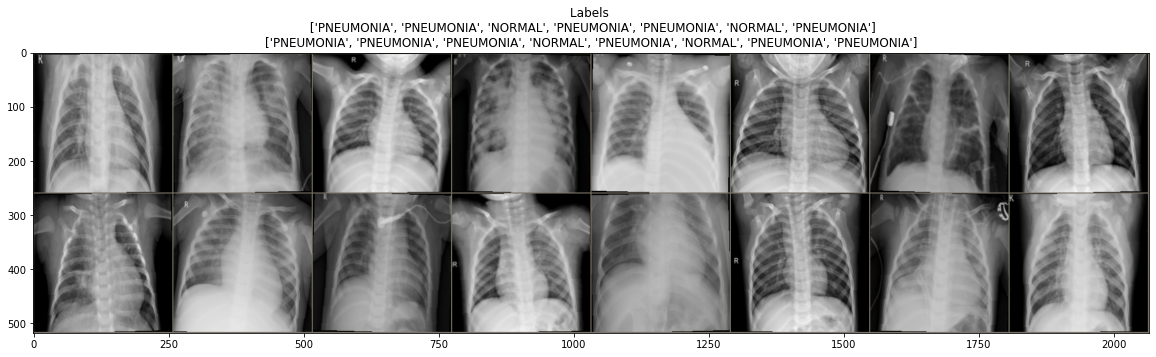

In [28]:
inputs,classes = next(iter(normDL1))
out = torchvision.utils.make_grid(inputs)
#Split the title

batchnames = [class_names[x] for x in classes]

imshow(out, title = "Labels \n "+ str(batchnames[:7])+"\n"+str(batchnames[8:]))

These look pretty good, they aren't "too" augmented (i.e. no big cropping, no reflections etc) so they still look like plausible x ray images, but the gaussian blur, brightness/exposure adjustments, and minor rotations should help bolster our training data. 

Note that because of the way we have our directories set up, we are going to create extra pnemo images as well, which we will need to separate when we re-load the saved images. 

Lets look at what a single element of our imagefolder looks like. 

In [30]:
extra_normal1[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

And lets double check that we know where the break between the classes are. 

In [32]:
extra_normal1[1340][-1]

0

In [33]:
extra_normal1[1341][-1]

1

Classes are stored as the last element with [:1341] being "normal and [1341:] being "pneumonia".

### Second set of transforms

In [34]:
normal_transforms2 = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.GaussianBlur(kernel_size=(5, 9),sigma=(1.0, 1.5)),
       # transforms.ColorJitter(hue=0),
        transforms.RandomAffine(degrees = 5),
        #transforms.RandomResizedCrop(224),
        transforms.RandomRotation(5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [35]:
extra_normal2 = datasets.ImageFolder(train_dir, transform = normal_transforms)

In [36]:
normDL2 = DataLoader(extra_normal1, batch_size = 16, shuffle = True, num_workers = 4,pin_memory=True)

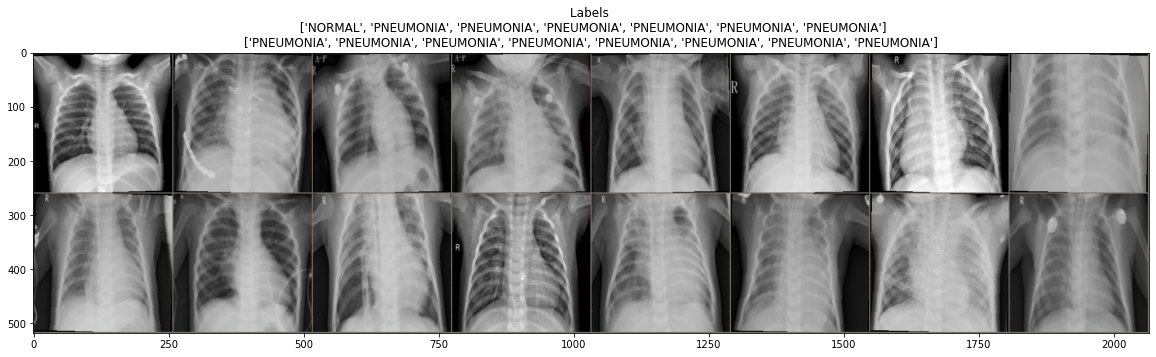

In [37]:
inputs,classes = next(iter(normDL2))
out = torchvision.utils.make_grid(inputs)

batchnames = [class_names[x] for x in classes]

imshow(out, title = "Labels \n "+ str(batchnames[:7])+"\n"+str(batchnames[8:]))

In [38]:
extra_normal1.classes

['NORMAL', 'PNEUMONIA']

save_image(img1, 'img1.png')

In [136]:
#normDL = DataLoader(extra_normal1, batch_size = 16, shuffle = True, num_workers = 4,pin_memory=True)

In [113]:
#type(train_data)

torchvision.datasets.folder.ImageFolder

### Final set of transforms for all training data

In [22]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.GaussianBlur(kernel_size=(5, 9),sigma=(0.1, 2.0)),
        #transforms.ColorJitter(hue=0),
        #transforms.RandomResizedCrop(224),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [25]:
train_data = datasets.ImageFolder(train_dir, transform = data_transforms['train'])
test_data = datasets.ImageFolder(test_dir, transform = data_transforms['test'])
val_data = datasets.ImageFolder(val_dir,transform = data_transforms['val'])

In [24]:
test_data = datasets.ImageFolder(test_dir, transform = data_transforms['test'])

In [26]:
train_data.classes

['NORMAL', 'PNEUMONIA']

In [27]:
class_names = train_data.classes

In [44]:
3875-1341-1341

1193

In [45]:
type(train_data)

torchvision.datasets.folder.ImageFolder

In [46]:
type(extra_normal1)

torchvision.datasets.folder.ImageFolder

### Adding the extra "normal" images back in
Now we will subset ~ 2500 normal images from the augmented data and mix them back in to our training set. 

In [47]:
e1 = torch.utils.data.Subset(extra_normal1, list(range(1341)))

In [48]:
type(e1)

torch.utils.data.dataset.Subset

In [55]:
e2 = torch.utils.data.Subset(extra_normal2, list(range(1193)))

In [56]:
AUGdataset = ConcatDataset([train_data, e1, e2])

In [57]:
len(AUGdataset)

7750

In [58]:
AUGdataset[0][-1]

0

In [59]:
#takes a while so will keep commented out in future runs
AUGcounts = [AUGdataset[i][-1] for i in range(len(AUGdataset))]

In [62]:
AUGco = dict(Counter(AUGcounts))

In [63]:
AUGco

{0: 3875, 1: 3875}

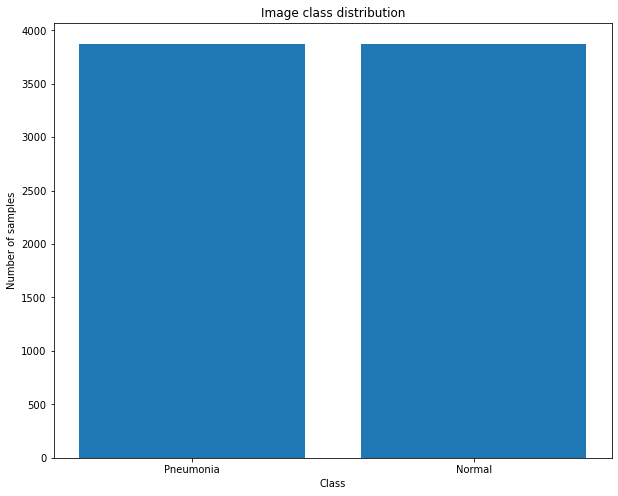

In [67]:
plt.figure(figsize = (10,8))
plt.bar(AUGco.keys(),AUGco.values())
plt.xlabel('Class')
plt.xticks(ticks = [0,1],labels=['Pneumonia','Normal'])
plt.ylabel('Number of samples')
plt.title('Image class distribution')
plt.show()

## Preprocessing & Modeling <a class="anchor" id="chapter2"></a>

We will employ transfer learning with a CNN trained on imagenet data. 

The way I am going to divide the data is to save the 624 "test" images for model evaluation/selection, and do an 80/20 split on the training data (now 7748 images), with the smaller split being our validation set to use during training. 

### Creating dataloaders for our datasets

In [71]:
total = len(AUGdataset)
print(total)

7750


In [72]:
train_size = int(0.8 * total)
val_size = total - train_size
train_data, val_data = torch.utils.data.random_split(AUGdataset, [train_size, val_size])

In [28]:
dataset_sizes = {'train': len(train_data), 'val':len(val_data),'test': len(test_data)}

In [29]:
dataset_sizes

{'train': 5216, 'val': 16, 'test': 624}

In [30]:
trainDL = DataLoader(train_data, batch_size = 32, shuffle = True, num_workers = 6,pin_memory=True)

In [30]:
#trainDL = DataLoader(train_data, batch_size = 16, shuffle = True, num_workers = 6)

In [31]:
valDL = DataLoader(val_data, batch_size = 16, shuffle = True, num_workers = 6, pin_memory = True)

In [32]:
testDL = DataLoader(test_data, batch_size = 16, shuffle = True, num_workers = 6, pin_memory = True)

In [33]:
dataloaders = {'train': trainDL, 'val':valDL, 'test':testDL}

In [137]:
#hispeed
trainDL = DataLoader(train_data, batch_size = 32, shuffle = True, num_workers = 0)
valDL = DataLoader(val_data, batch_size = 32, shuffle = True, num_workers = 0)
testDL = DataLoader(test_data, batch_size = 32, shuffle = True, num_workers = 0)

Lets take a look at what a single batch from our training data looks like

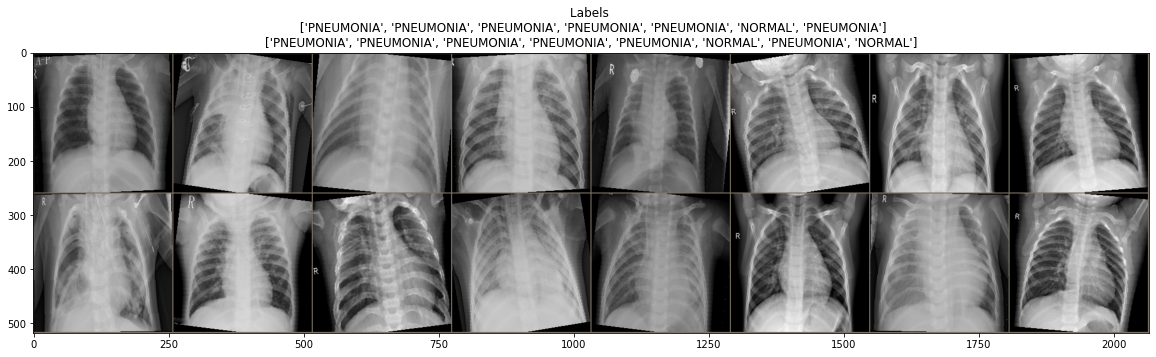

In [34]:
# Get a batch of training data
inputs, classes = next(iter(trainDL))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#Split the title

batchnames = [class_names[x] for x in classes]

imshow(out, title = "Labels \n "+ str(batchnames[:7])+"\n"+str(batchnames[8:]))

# Model Training 

The following 2 functions are modified from the pytorch transfer learning tutorial documentation which can be found at the following link. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html



In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [38]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize = (8,8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.plot(figsize = (8,8))
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                plt.xlabel(labels[j])
                imshow(inputs.cpu().data[j],figsize = (4,4))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Transfer Learning with Resnet18

In [36]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [37]:
#load in the pretrained model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Here is where we begin training

In [39]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 0.1484 Acc: 0.9427
val Loss: 0.1590 Acc: 1.0000

Epoch 1/14
----------
train Loss: 0.0635 Acc: 0.9785
val Loss: 0.2712 Acc: 0.8750

Epoch 2/14
----------
train Loss: 0.0475 Acc: 0.9827
val Loss: 0.2166 Acc: 0.9375

Epoch 3/14
----------
train Loss: 0.0393 Acc: 0.9860
val Loss: 0.0882 Acc: 1.0000

Epoch 4/14
----------
train Loss: 0.0307 Acc: 0.9906
val Loss: 0.2725 Acc: 0.8125

Epoch 5/14
----------
train Loss: 0.0272 Acc: 0.9895
val Loss: 0.0595 Acc: 1.0000

Epoch 6/14
----------
train Loss: 0.0200 Acc: 0.9941
val Loss: 0.1147 Acc: 0.9375

Epoch 7/14
----------
train Loss: 0.0150 Acc: 0.9950
val Loss: 0.1844 Acc: 0.8750

Epoch 8/14
----------
train Loss: 0.0137 Acc: 0.9965
val Loss: 0.2088 Acc: 0.8750

Epoch 9/14
----------
train Loss: 0.0114 Acc: 0.9967
val Loss: 0.1456 Acc: 0.8750

Epoch 10/14
----------
train Loss: 0.0182 Acc: 0.9939
val Loss: 0.1263 Acc: 0.9375

Epoch 11/14
----------
train Loss: 0.0138 Acc: 0.9958
val Loss: 0.1049 Acc: 0.9375

Ep

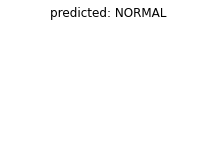

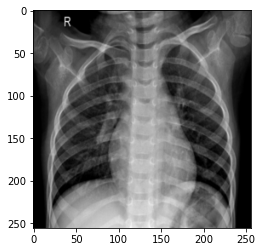

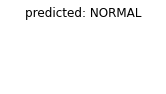

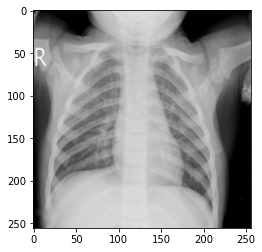

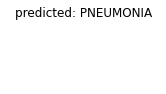

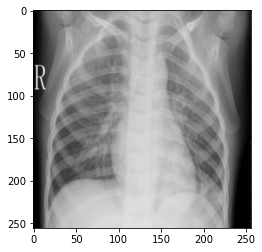

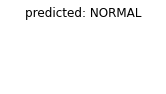

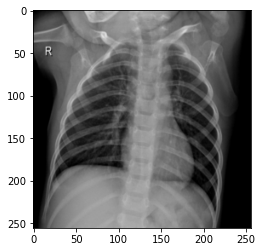

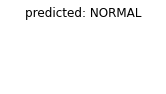

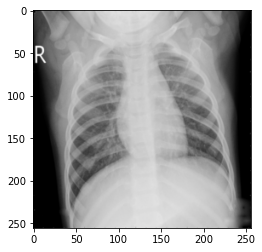

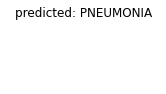

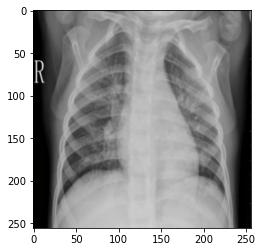

In [41]:
visualize_model(model_ft)

In [201]:
dataloaders['test']

In [42]:
test_load = DataLoader(test_data, batch_size = 1)

In [43]:
def ez_metrics(model, test_data = test_data):
    from sklearn.metrics import classification_report, f1_score
    from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

    test_load = DataLoader(test_data, batch_size = 1)
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        for imgs, labels in test_load:
            x_batch, y_batch = imgs.to(device), labels.to(device)
            y_test_pred = model_ft(x_batch)
            y_test_pred = torch.log_softmax(y_test_pred, dim=1)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(y_batch.cpu().numpy())
    y_pred_list = [i[0] for i in y_pred_list]
    y_true_list = [i[0] for i in y_true_list]
    print(classification_report(y_true_list, y_pred_list))
    print("Accuracy Score:  ", accuracy_score(y_true_list, y_pred_list))
    print("F1 Score:  ", f1_score(y_true_list, y_pred_list))
    fig, ax = plt.subplots(figsize=(8,6))
    cm = confusion_matrix(y_true_list, y_pred_list)
    disp = ConfusionMatrixDisplay(cm, display_labels = [0,1])
    disp.plot(ax=ax)  
    return y_pred_list, y_true_list

In [44]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for imgs, labels in test_load:
        x_batch, y_batch = imgs.to(device), labels.to(device)
        y_test_pred = model_ft(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [45]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [46]:
len(y_pred_list)

624

In [49]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import  f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


In [50]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89       234
           1       0.91      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.91      0.92       624
weighted avg       0.93      0.92      0.92       624



In [51]:
accuracy_score(y_true_list, y_pred_list)

0.9246794871794872

In [122]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

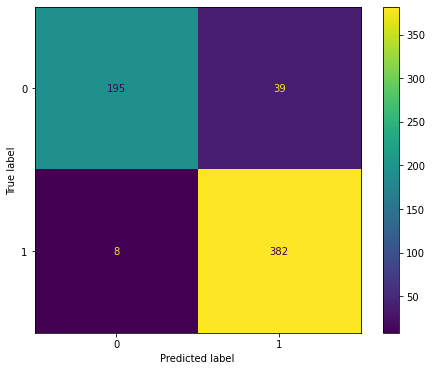

In [52]:
fig, ax = plt.subplots(figsize=(8,6))
cm = confusion_matrix(y_true_list, y_pred_list)
disp = ConfusionMatrixDisplay(cm, display_labels = [0,1])
disp.plot(ax=ax)      

false positives are better than false negatives

In [53]:
f1_score(y_true_list, y_pred_list)

0.9420468557336622

In [54]:
#torch.save(model_ft.state_dict(), '../models/model92A-ft')

In [69]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Feature extraction

Freezing the network except for the final layer. 

In [55]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [56]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 0.2871 Acc: 0.8800
val Loss: 0.2473 Acc: 0.8750

Epoch 1/14
----------
train Loss: 0.1712 Acc: 0.9381
val Loss: 0.2383 Acc: 0.8750

Epoch 2/14
----------
train Loss: 0.1499 Acc: 0.9446
val Loss: 0.2771 Acc: 0.8750

Epoch 3/14
----------
train Loss: 0.1463 Acc: 0.9431
val Loss: 0.4650 Acc: 0.7500

Epoch 4/14
----------
train Loss: 0.1327 Acc: 0.9511
val Loss: 0.2010 Acc: 0.9375

Epoch 5/14
----------
train Loss: 0.1239 Acc: 0.9551
val Loss: 0.2786 Acc: 0.8750

Epoch 6/14
----------
train Loss: 0.1247 Acc: 0.9534
val Loss: 0.3898 Acc: 0.8750

Epoch 7/14
----------
train Loss: 0.1237 Acc: 0.9528
val Loss: 0.3414 Acc: 0.8750

Epoch 8/14
----------
train Loss: 0.1171 Acc: 0.9559
val Loss: 0.4124 Acc: 0.7500

Epoch 9/14
----------
train Loss: 0.1217 Acc: 0.9536
val Loss: 0.3421 Acc: 0.8750

Epoch 10/14
----------
train Loss: 0.1217 Acc: 0.9546
val Loss: 0.3753 Acc: 0.8750

Epoch 11/14
----------
train Loss: 0.1245 Acc: 0.9538
val Loss: 0.3985 Acc: 0.7500

Ep

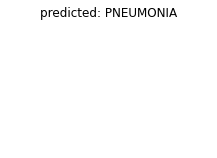

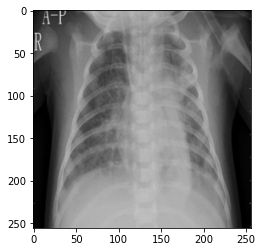

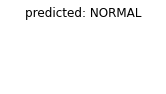

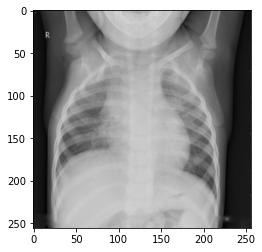

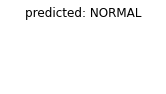

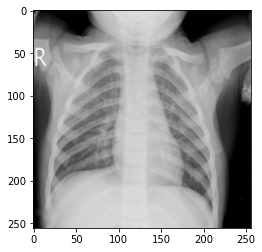

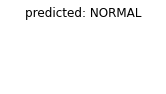

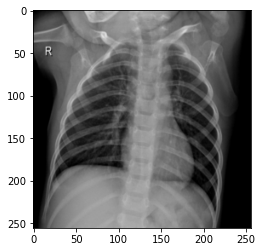

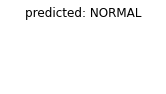

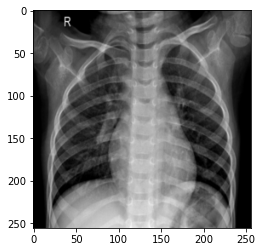

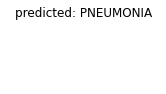

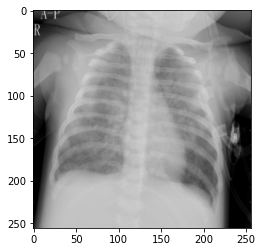

In [57]:
visualize_model(model_conv)


In [64]:
test_load = DataLoader(test_data, batch_size = 1)

In [58]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for imgs, labels in test_load:
        x_batch, y_batch = imgs.to(device), labels.to(device)
        y_test_pred = model_conv(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [59]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [60]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.93      0.81      0.86       234
           1       0.89      0.96      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.89      0.90       624
weighted avg       0.91      0.91      0.90       624



In [61]:
f1_score(y_true_list, y_pred_list)

0.9272503082614056

In [62]:
accuracy_score(y_true_list, y_pred_list)

0.905448717948718

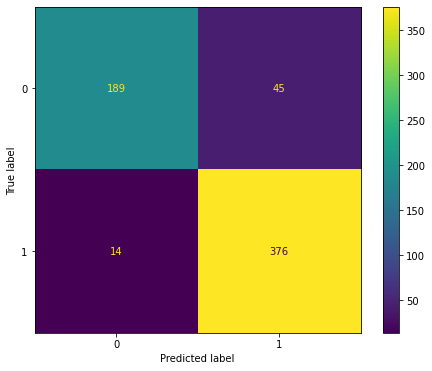

In [63]:
fig, ax = plt.subplots(figsize=(8,6))
cm = confusion_matrix(y_true_list, y_pred_list)
disp = ConfusionMatrixDisplay(cm, display_labels = [0,1])
disp.plot(ax=ax)      

In [65]:
torch.save(model_ft.state_dict(), '../models/model15-90A-Fr')

In [70]:
model_conv

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
from torchvision.models import resnet50, vgg19

In [39]:
#load in the pretrained model
model_ft = vgg19(pretrained=True)
#num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(512, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [40]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize = (8,8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.plot(figsize = (8,8))
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                plt.xlabel(labels[j])
                imshow(inputs.cpu().data[j],figsize = (4,4))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Here is where we begin training

In [41]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 6.00 GiB total capacity; 3.38 GiB already allocated; 0 bytes free; 3.47 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

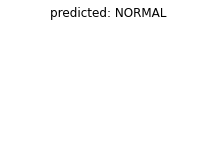

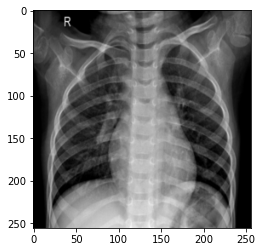

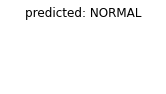

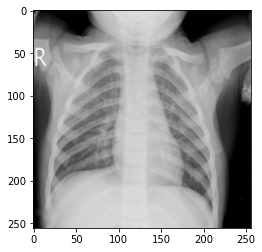

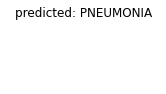

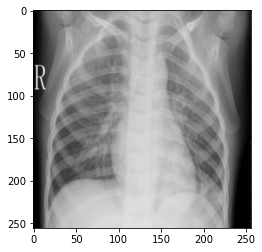

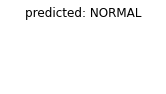

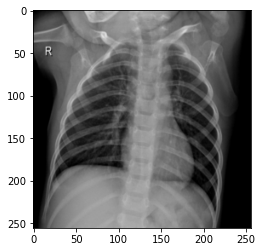

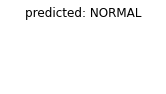

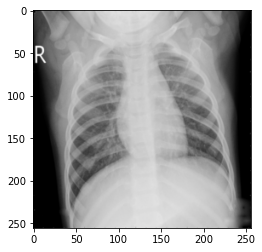

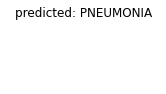

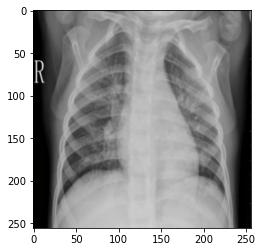

In [41]:
visualize_model(model_ft)

In [201]:
dataloaders['test']

In [42]:
test_load = DataLoader(test_data, batch_size = 1)

In [43]:
def ez_metrics(model, test_data = test_data):
    from sklearn.metrics import classification_report, f1_score
    from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

    test_load = DataLoader(test_data, batch_size = 1)
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        for imgs, labels in test_load:
            x_batch, y_batch = imgs.to(device), labels.to(device)
            y_test_pred = model_ft(x_batch)
            y_test_pred = torch.log_softmax(y_test_pred, dim=1)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(y_batch.cpu().numpy())
    y_pred_list = [i[0] for i in y_pred_list]
    y_true_list = [i[0] for i in y_true_list]
    print(classification_report(y_true_list, y_pred_list))
    print("Accuracy Score:  ", accuracy_score(y_true_list, y_pred_list))
    print("F1 Score:  ", f1_score(y_true_list, y_pred_list))
    fig, ax = plt.subplots(figsize=(8,6))
    cm = confusion_matrix(y_true_list, y_pred_list)
    disp = ConfusionMatrixDisplay(cm, display_labels = [0,1])
    disp.plot(ax=ax)  
    return y_pred_list, y_true_list

In [44]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for imgs, labels in test_load:
        x_batch, y_batch = imgs.to(device), labels.to(device)
        y_test_pred = model_ft(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [45]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [46]:
len(y_pred_list)

624

In [49]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import  f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


In [50]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89       234
           1       0.91      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.91      0.92       624
weighted avg       0.93      0.92      0.92       624



In [51]:
accuracy_score(y_true_list, y_pred_list)

0.9246794871794872

In [122]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

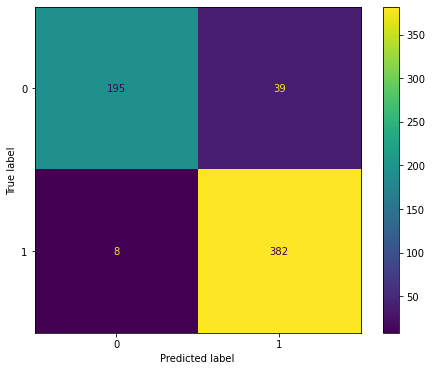

In [52]:
fig, ax = plt.subplots(figsize=(8,6))
cm = confusion_matrix(y_true_list, y_pred_list)
disp = ConfusionMatrixDisplay(cm, display_labels = [0,1])
disp.plot(ax=ax)      

false positives are better than false negatives

In [53]:
f1_score(y_true_list, y_pred_list)

0.9420468557336622

In [54]:
#torch.save(model_ft.state_dict(), '../models/model92A-ft')

In [69]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#torch.utils.data.WeightedRandomSampler(weights, num_samples = 7750, replacement=True, generator=None)

In [ ]:
#dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              #for x in ['train', 'test']}

    #https://marekpaulik.medium.com/imbalanced-dataset-image-classification-with-pytorch-6de864982eb1
    def load_data(self):
        train_full = torchvision.datasets.ImageFolder(self.data_dir, transform=self.Transform)
        train_set, val_set = random_split(train_full, [math.floor(len(train_full)*0.8), math.ceil(len(train_full)*0.2)])

        self.train_classes = [label for _, label in train_set]
        if self.sample:
            # Need to get weight for every image in the dataset
            class_count = Counter(self.train_classes)
            class_weights = torch.Tensor([len(self.train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
            # Can't iterate over class_count because dictionary is unordered

            sample_weights = [0] * len(train_set)
            for idx, (image, label) in enumerate(train_set):
                class_weight = class_weights[label]
                sample_weights[idx] = class_weight

            sampler = WeightedRandomSampler(weights=sample_weights,
                                            num_samples = len(train_set), replacement=True)  
            train_loader = DataLoader(train_set, batch_size=self.batch_size, sampler=sampler)
        else:
            train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)

        val_loader = DataLoader(val_set, batch_size=self.batch_size)

        return train_loader, val_loader

    correct_count, all_count = 0, 0
    for images,labels in test_load:
        for i in range(len(labels)):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            img = images[i].view(1, 3, 224, 224)
        with torch.no_grad():
            logps = model_ft(img)


        ps = torch.exp(logps)
        probab = list(ps.cpu()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.cpu()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

    print("Number Of Images Tested =", all_count)
    print("\nModel Accuracy =", (correct_count/all_count)) 

    def imshow(inp, title=None):
        """Imshow for Tensor.
        This function is from the PyTorch transfer learning tutorial notebook
        """
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)  # pause a bit so that plots are updated


    # Get a batch of training data
    inputs, classes = next(iter(dataloaders['train']))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[class_names[x] for x in classes])

    https://pytorch.org/vision/stable/feature_extraction.html

In [53]:
from torchvision.models.segmentation import fcn_resnet50
from torchvision.models.segmentation import FCN_ResNet50_Weights
#, FCN_ResNet50_Weights
#model = fcn_resnet50()
weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(weights=weights, progress=False)
model = model.eval()

batch = torch.stack([transforms(d) for d in pnemo_pics[:5]])
output = model(batch)['out']
print(output.shape, output.min().item(), output.max().item())

ImportError: cannot import name 'FCN_ResNet50_Weights' from 'torchvision.models.segmentation' (C:\Users\alber\anaconda3\lib\site-packages\torchvision\models\segmentation\__init__.py)

https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py

In [ ]:
# https://pyimagesearch.com/2021/10/04/image-data-loaders-in-pytorch/
# load all the image paths and randomly shuffle them
print("[INFO] loading image paths...")
imagePaths = list(paths.list_images(config.FLOWERS_DATASET_PATH))
np.random.shuffle(imagePaths)
# generate training and validation paths
valPathsLen = int(len(imagePaths) * config.VAL_SPLIT)
trainPathsLen = len(imagePaths) - valPathsLen
trainPaths = imagePaths[:trainPathsLen]
valPaths = imagePaths[trainPathsLen:]
# copy the training and validation images to their respective
# directories
print("[INFO] copying training and validation images...")
copy_images(trainPaths, config.TRAIN)
copy_images(valPaths, config.VAL)



def visualize_batch(batch, classes, dataset_type):
	# initialize a figure
	fig = plt.figure("{} batch".format(dataset_type),
		figsize=(config.BATCH_SIZE, config.BATCH_SIZE))
	# loop over the batch size
	for i in range(0, config.BATCH_SIZE):
		# create a subplot
		ax = plt.subplot(2, 4, i + 1)
		# grab the image, convert it from channels first ordering to
		# channels last ordering, and scale the raw pixel intensities
		# to the range [0, 255]
		image = batch[0][i].cpu().numpy()
		image = image.transpose((1, 2, 0))
		image = (image * 255.0).astype("uint8")
		# grab the label id and get the label from the classes list
		idx = batch[1][i]
		label = classes[idx]
		# show the image along with the label
		plt.imshow(image)
		plt.title(label)
		plt.axis("off")
	# show the plot
	plt.tight_layout()
	plt.show()
    
trainBatch = next(iter(trainDataLoader))
valBatch = next(iter(valDataLoader))
# visualize the training and validation set batches
print("[INFO] visualizing training and validation batch...")
visualize_batch(trainBatch, trainDataset.classes, "train")
visualize_batch(valBatch, valDataset.classes, "val")

In [ ]:
#https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)